## Basics of TS:

Collation of different basic concepts of the different traditional time-series models and some basic intuition behind them

## Objective:
This kernel was made to serve as repository of various time-series concepts for beginners and I hope it would be useful as a refresher to some of the experts too :)

## Table of contents:
* Competition and data overview
* Imports ( data and packages )
* Basic exploration/EDA
* Single time-series 
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
* Hierarchical time-series
    * Bottom's up
    * AHP
    * PHA 
    * FP 
    
    
## Competition and data overview:

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm). 

**What does the IC company do?:**

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

**Data**:
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.

## Descrição dos Dados

#TODO
- Utilizando a série de vendas totais, tentar diferenciar para retirar a tendência e fittar um sarima (tunar o modelo, achar melhores parâmetros), mais fácil de fazer no R talvez, até o momento não encontramos nenhuma solução prática já implementada para fazer a busca pelos melhores parâmetros em Python

- PYTHON - ao invés de trabalhar com o total de itens vendidos, trabalhar com a média dos itens vendidos, ou seja, dividir o total itens vendidos (série atual) pela quantidade de lojas e seguir a análise tal como já feita neste notebook (decompor série, testar estacionariedade, achar melhor ARMA, ARIMA e SARIMA)

obs - olhar funções arma_tune, arima_tune e sarima_tune para selecionar melhor modelo com base no aic


### Funções


In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic, kpss
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.statespace.tools import diff

# settings
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15,7]


In [3]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

# remover tendência
from pandas import Series as Series
# diferenciar a série
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [4]:
# leitura dos dados
sales=pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
# sales = sales.sample(n = 1000, random_state = 42)

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
item=pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
sub=pd.read_csv("competitive-data-science-predict-future-sales/sample_submission.csv")
shops=pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
test=pd.read_csv("competitive-data-science-predict-future-sales/test.csv")

In [5]:
#formatando a coluna de data
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None



# Série de Vendas Totais:



Queremos construir um modelo capaz de predizer o total de vendas por mês de toda a companhia.

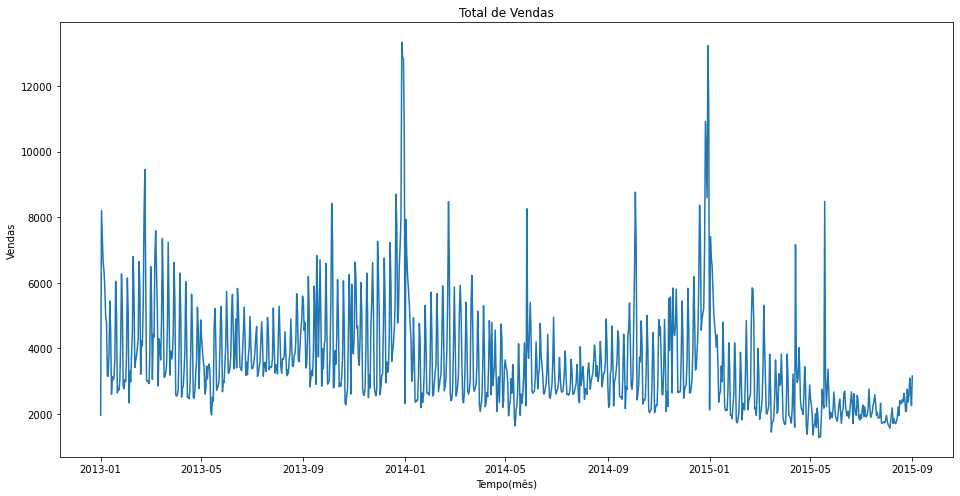

In [6]:
ts=sales.groupby(by=['date'])["item_cnt_day"].sum()
teste = ts.iloc[974:]
ts = ts.iloc[:-60]

ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total de Vendas')
plt.xlabel('Tempo(mês)')
plt.ylabel('Vendas')
plt.plot(ts);

Percebe a provável presença de sazonalidade na série, visto que temos picos semelhantemente espaçados em toda sua duração. Além disso, como as vendas parecem diminuir com o tempo, notamos também uma tendência decrescente.

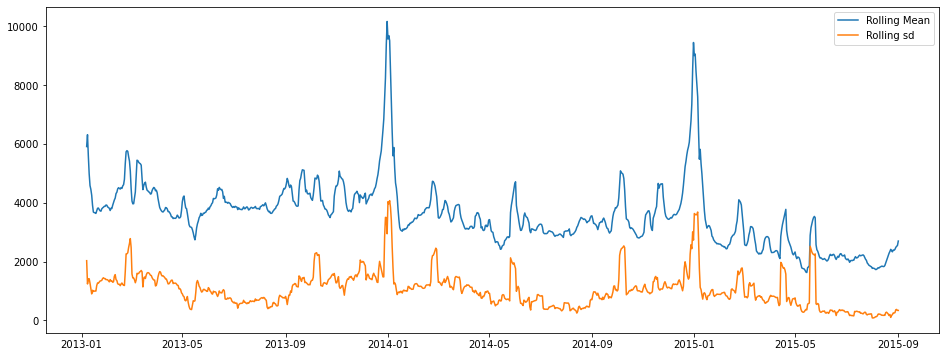

In [7]:
plt.figure(figsize=(16,6))
w=7
plt.plot(ts.rolling(window=w,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=w,center=False).std(),label='Rolling sd');
plt.legend();

Com base na existência de tendência e sazonalidade, podemos adotar dois tipos de modelos:
    
Aditivo:
$$
Y_{t} = S_{t} + T_{t} + Z_{t}
$$

Multiplicativo:
$$
Y_{t} = S_{t}T_{t}Z_{t}
$$


Em ambos os modelos aplicamos uma de composição por média móveis com período de sazonalidade de 365 dias (faz sentido?)

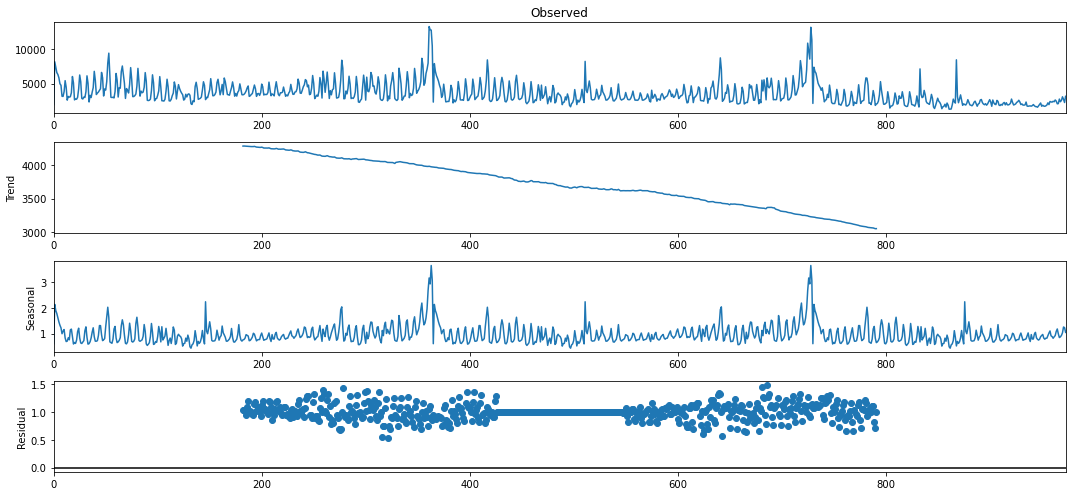

In [35]:

# multiplicative
resm = sm.tsa.seasonal_decompose(ts.values,period=365,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = resm.plot()
fig.show()

# salva resíduos
residuos = pd.DataFrame(resm.resid)
residuos = residuos.dropna()[0].to_numpy()

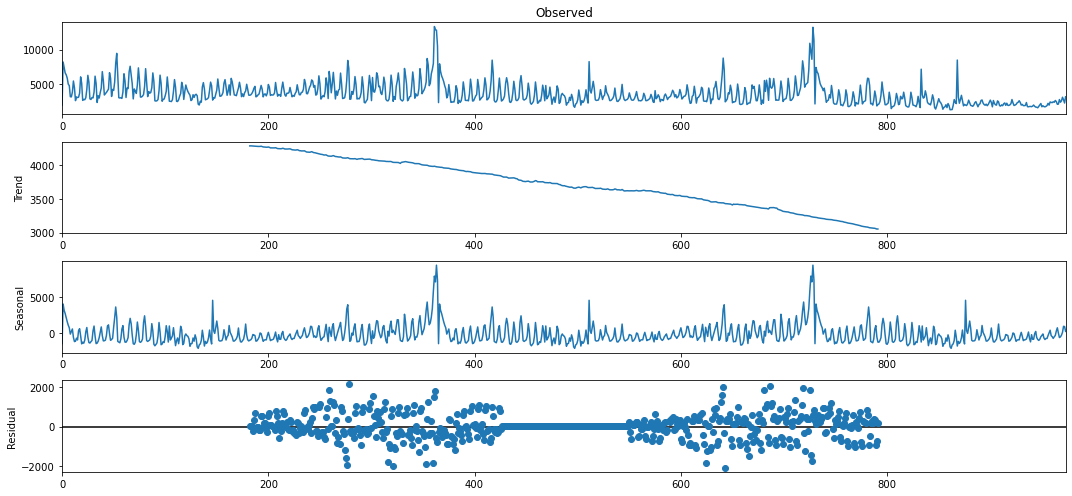

In [9]:
# Additive model
resa = sm.tsa.seasonal_decompose(ts.values,period=365,model="additive")
# plt.figure(figsize=(30,12))
resa.plot()
plt.show()

# salva resíduos
residuos = pd.DataFrame(resa.resid)
residuos = residuos.dropna()[0].to_numpy()

In [10]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(residuos)


Results of Dickey-Fuller Test:
Test Statistic                -5.679140e+00
p-value                        8.566394e-07
#Lags Used                     1.400000e+01
Number of Observations Used    5.950000e+02
Critical Value (1%)           -3.441388e+00
Critical Value (5%)           -2.866410e+00
Critical Value (10%)          -2.569363e+00
dtype: float64


In [11]:
# ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
# ts.astype('float')
# plt.figure(figsize=(16,16))
# plt.subplot(311)
# plt.title('Original')
# plt.xlabel('Time')
# plt.ylabel('Sales')
# plt.plot(resa)
# plt.subplot(312)
# plt.title('After De-trend')
# plt.xlabel('Time')
# plt.ylabel('Sales')
# new_ts=difference(resa)
# plt.plot(new_ts)
# plt.plot()

# plt.subplot(313)
# plt.title('After De-seasonalization')
# plt.xlabel('Time')
# plt.ylabel('Sales')
# new_ts=difference(resa,365)       # assuming the seasonality is 12 months long
# plt.plot(new_ts)
# plt.plot()

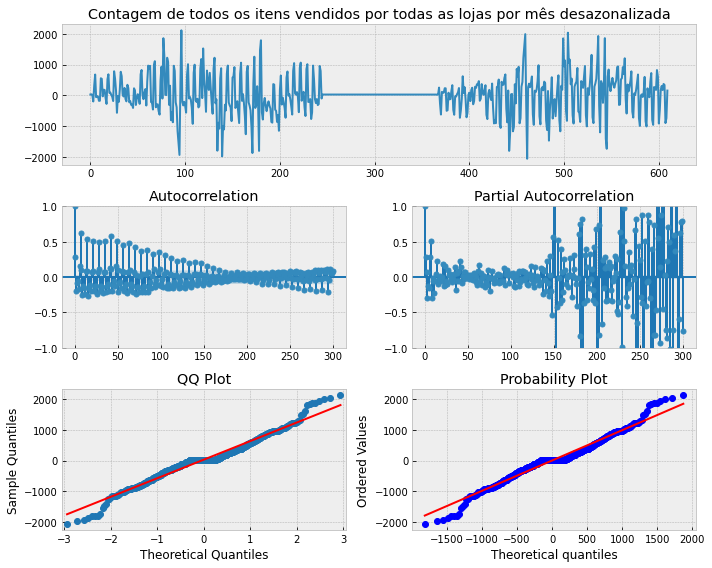

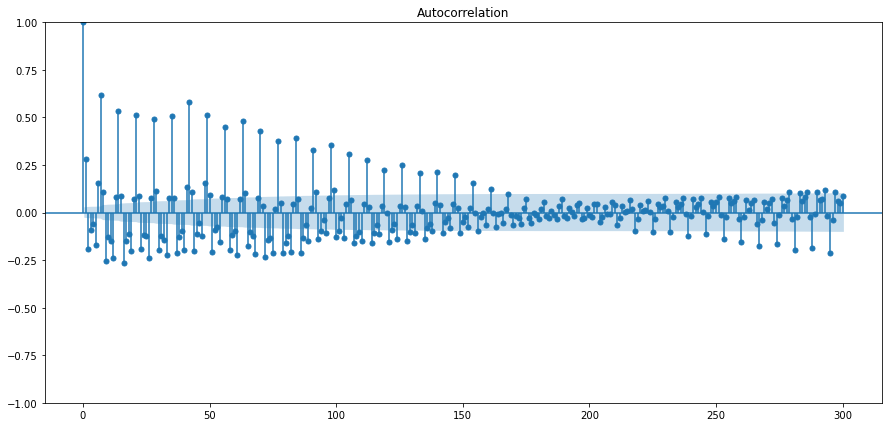

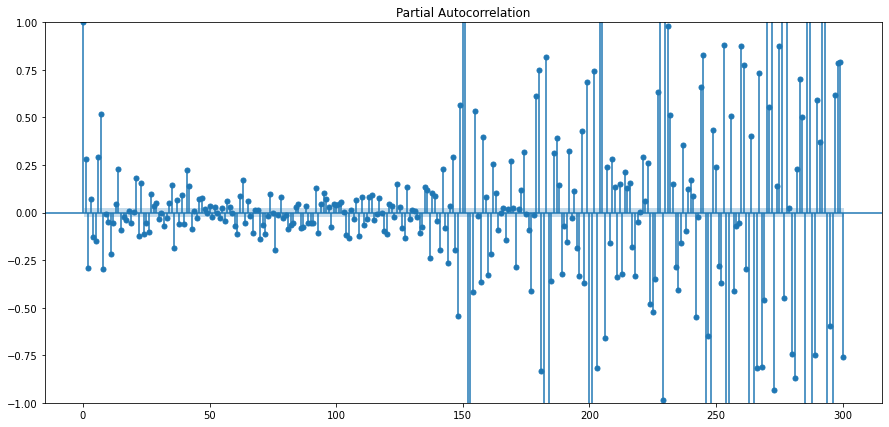

In [12]:
tsplot(residuos, lags=300,title="Contagem de todos os itens vendidos por todas as lojas por mês desazonalizada")
acf =smt.graphics.plot_acf(residuos, lags=300, alpha=0.5)
pacf = smt.graphics.plot_pacf(residuos, lags=300,  alpha=0.53)

## ARMA

In [13]:
# pick best order by aic 
# smallest aic value wins



def arma_tune(data, rng = 4):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    rng = range(rng)
    for i in rng:
        for j in rng:
            try:
                tmp_mdl = ARIMA(data, order=(i, 0, j)).fit()#ARIMA(arma22, order=(i, 0, j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print(i,j,tmp_aic)
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
                    
            except: continue


    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

    
#arma_tune(residuos, rng = 4)


In [14]:
model = ARIMA(residuos, order=(2, 0, 3)).fit()
resid_arma23 = model.resid
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  610
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -4651.836
Date:                Mon, 05 Dec 2022   AIC                           9317.672
Time:                        21:48:32   BIC                           9348.566
Sample:                             0   HQIC                          9329.690
                                - 610                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2932     28.774      0.949      0.343     -29.103      83.689
ar.L1         -0.4476      0.006    -69.963      0.000      -0.460      -0.435
ar.L2         -0.9956      0.006   -157.857      0.0

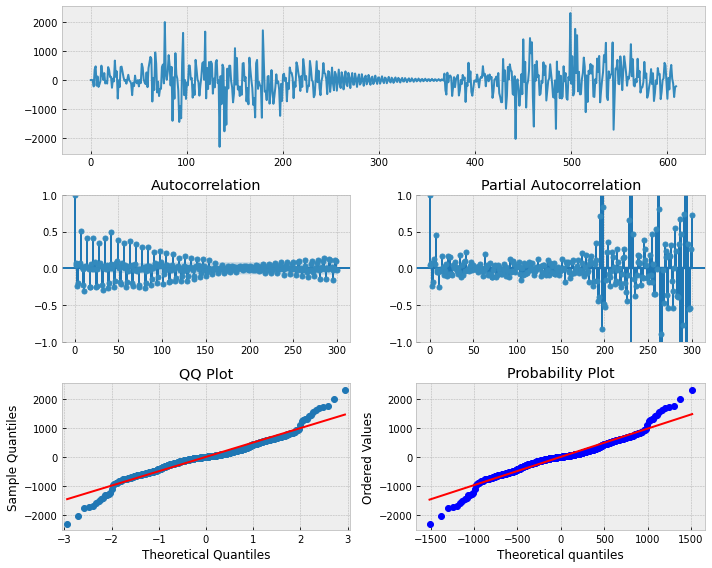

In [15]:
tsplot(resid_arma23, lags = 300)

In [16]:
## antigo
model = ARIMA(residuos, order=(3, 0, 3)).fit()
model_arma33 = model.resid
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  610
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -4681.359
Date:                Mon, 05 Dec 2022   AIC                           9378.717
Time:                        21:48:34   BIC                           9414.025
Sample:                             0   HQIC                          9392.451
                                - 610                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2913     30.091      0.907      0.364     -31.685      86.268
ar.L1          0.3954      0.103      3.822      0.000       0.193       0.598
ar.L2         -0.1252      0.077     -1.622      0.1

## ARIMA

In [17]:
# pick best order by aic 
# smallest aic value wins

def arima_tune(data, rng = 4):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    rng = range(rng)
    for i in rng:
        for j in rng:
            for k in rng:
                try:
                    tmp_mdl = ARIMA(residuos, order=(i, k, j)).fit()#ARIMA(arma22, order=(i, 0, j)).fit(method='mle', trend='nc')
                    # print(tmp_mdl)
                    tmp_aic = tmp_mdl.aic
                    print(i,k,j,tmp_aic)
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i,k, j)
                        best_mdl = tmp_mdl
                except: continue


    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

#arima_tune(data, rng = 4)


In [18]:
model_arima133 = ARIMA(residuos, order=(1, 3, 3)).fit()
resid_arima133 = model_arima133.resid
print(model_arima133.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  610
Model:                 ARIMA(1, 3, 3)   Log Likelihood               -1453.981
Date:                Mon, 05 Dec 2022   AIC                           2917.963
Time:                        21:48:35   BIC                           2940.005
Sample:                             0   HQIC                          2926.539
                                - 610                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.01e-07   9.89e+06      0.000       1.000       1.000
ma.L1         -3.0000      1.009     -2.973      0.003      -4.978      -1.022
ma.L2          3.0000      0.509      5.898      0.0

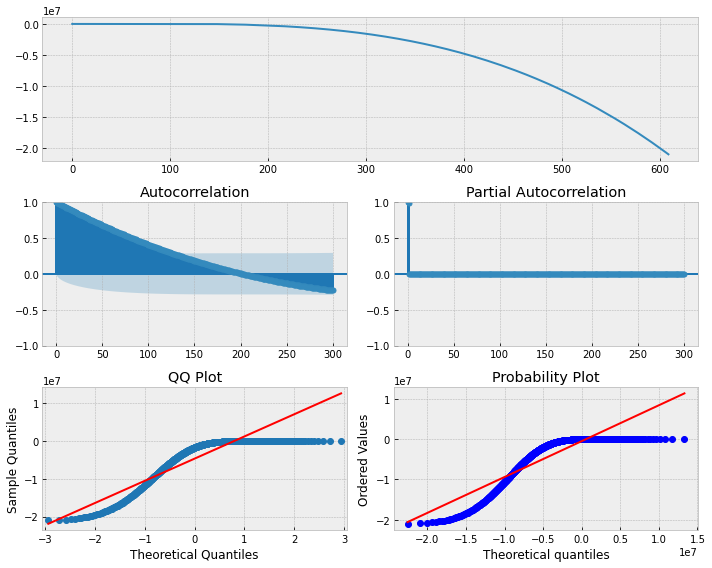

In [19]:
tsplot(resid_arima133, lags = 300)

### SARIMA

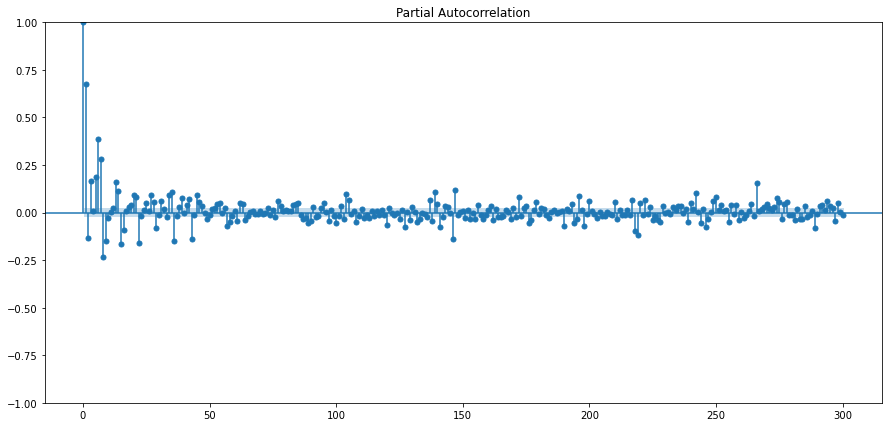

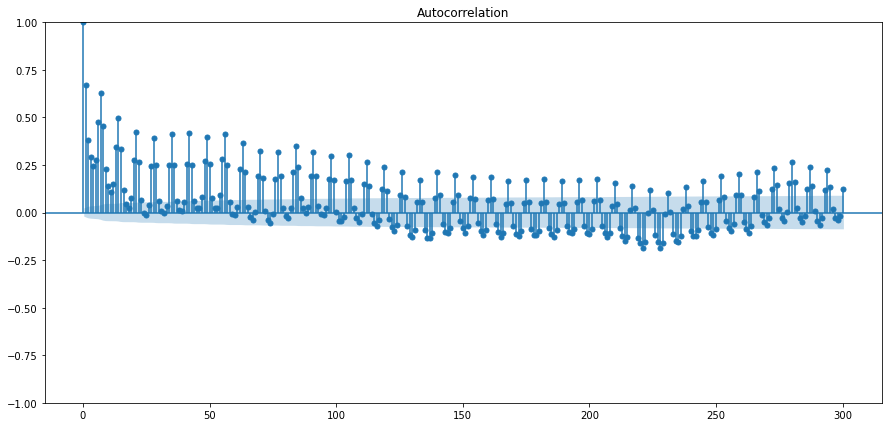

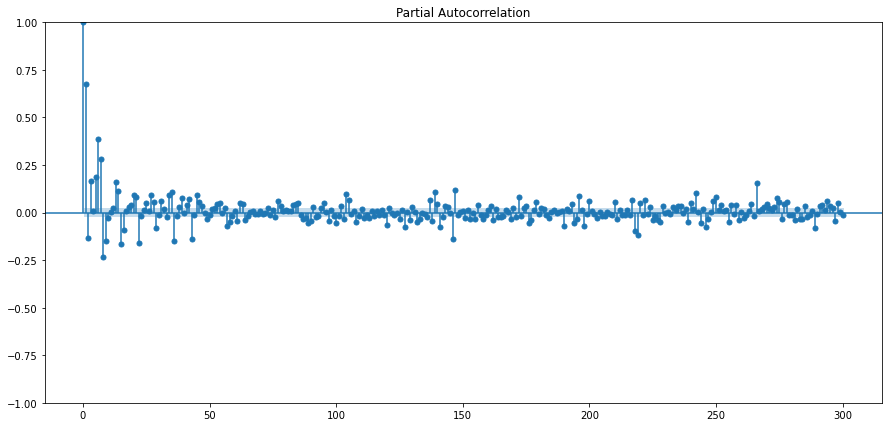

In [20]:
#tsplot(ts, lags = 300)
smt.graphics.plot_acf(ts, lags=300, alpha=0.5)
smt.graphics.plot_pacf(ts,lags=300, alpha=0.5)

In [21]:
# série sem retirar componente sazonal e tendência
# model_sarima = ARIMA(ts, order=(3, 1, 3), seasonal_order=(1, 0, 1, 7)).fit()
# resid_sarima = model_sarima.resid
# print(model_sarima.summary())
# tsplot(resid_sarima)

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  610
Model:             ARIMA(3, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -4517.943
Date:                           Mon, 05 Dec 2022   AIC                           9053.885
Time:                                   21:48:37   BIC                           9093.592
Sample:                                        0   HQIC                          9069.332
                                           - 610                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8942      0.028    -32.208      0.000      -0.949      -0.840
ar.L2         -0.4938      0.036    -13.570

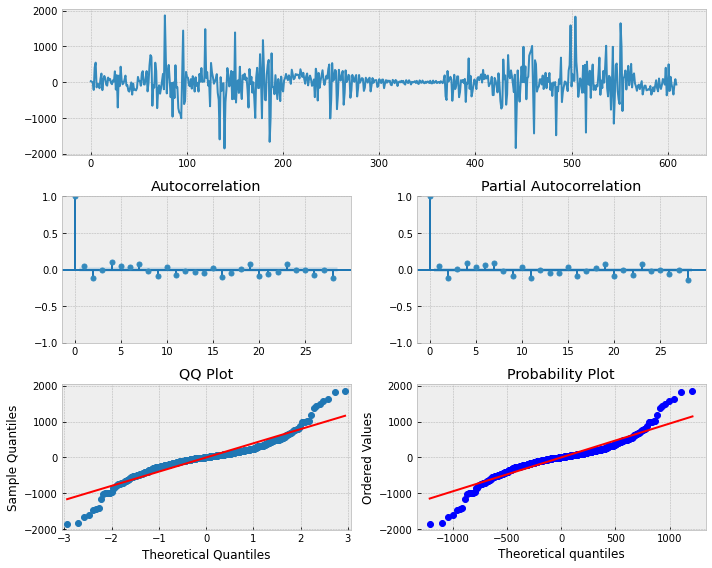

In [22]:
model_sarima = ARIMA(residuos, order=(3, 1, 3), seasonal_order=(1, 0, 1, 7)).fit()
resid_sarima = model_sarima.resid
print(model_sarima.summary())
tsplot(resid_sarima)

In [23]:
def sarima_tune(data, rng = 4):
    
    # seasonal_order, na linha 14, está fixada para sazonalidade de 7 dias, talvez seja preciso mudar
    
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    rng = range(rng)
    for i in rng:
        for j in rng:
            for k in rng:
                try:
                    tmp_mdl = ARIMA(residuos, order=(i, k, j), seasonal_order=(1, 0, 1, 7)).fit()
                    # print(tmp_mdl)
                    tmp_aic = tmp_mdl.aic
                    print(i,k,j,tmp_aic)
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i,k, j)
                        best_mdl = tmp_mdl
                except: continue


    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

#sarima_tune(residuos)


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  610
Model:             ARIMA(3, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -4514.090
Date:                           Mon, 05 Dec 2022   AIC                           9048.180
Time:                                   21:48:39   BIC                           9092.315
Sample:                                        0   HQIC                          9065.348
                                           - 610                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3785   1640.952      0.017      0.987   -3188.828    3243.585
ar.L1         -1.2040      0.189     -6.360

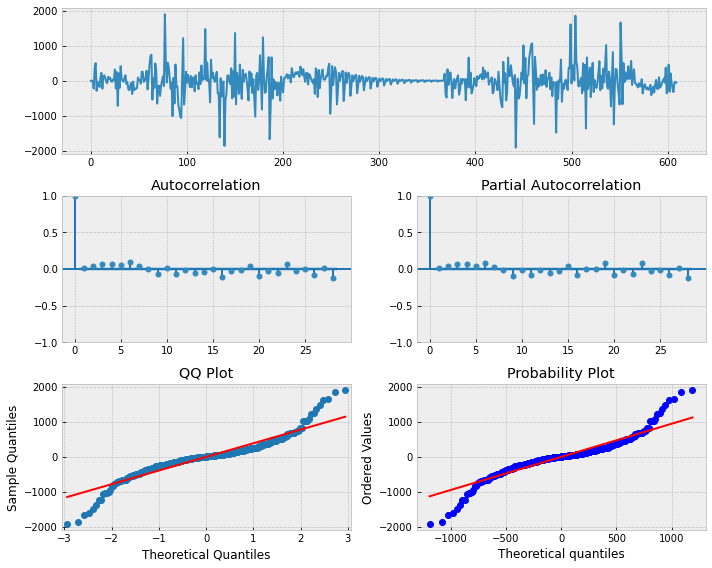

In [24]:
model_sarima = ARIMA(residuos, order=(3, 0, 3), seasonal_order=(1, 0, 1, 7)).fit()
resid_sarima = model_sarima.resid
print(model_sarima.summary())
tsplot(resid_sarima)

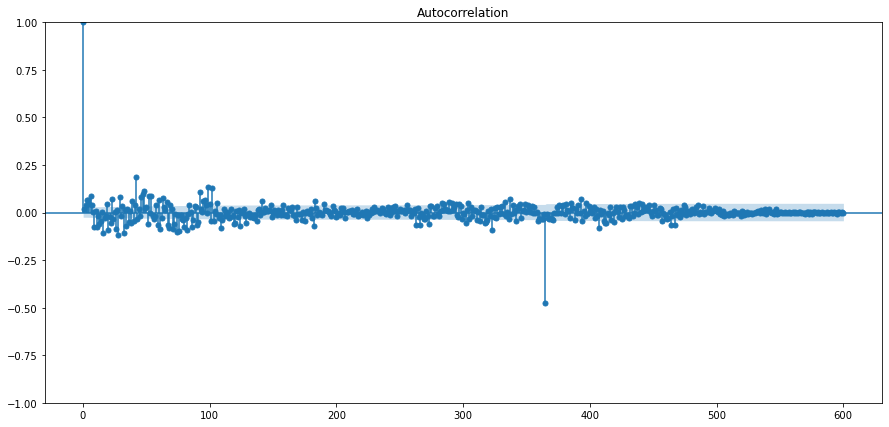

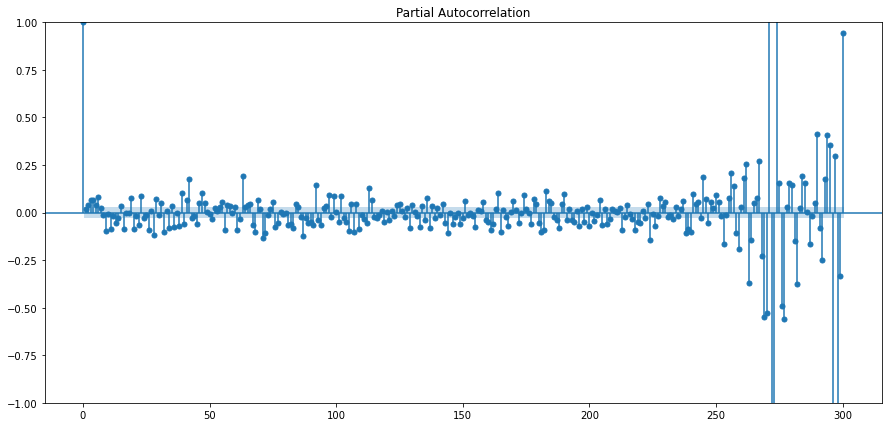

In [25]:
acf = smt.graphics.plot_acf(resid_sarima, lags=600, alpha=0.5, use_vlines = True)
pacf = smt.graphics.plot_pacf(resid_sarima,lags=300, alpha=0.5)

# Sazonalidade de 7 dias

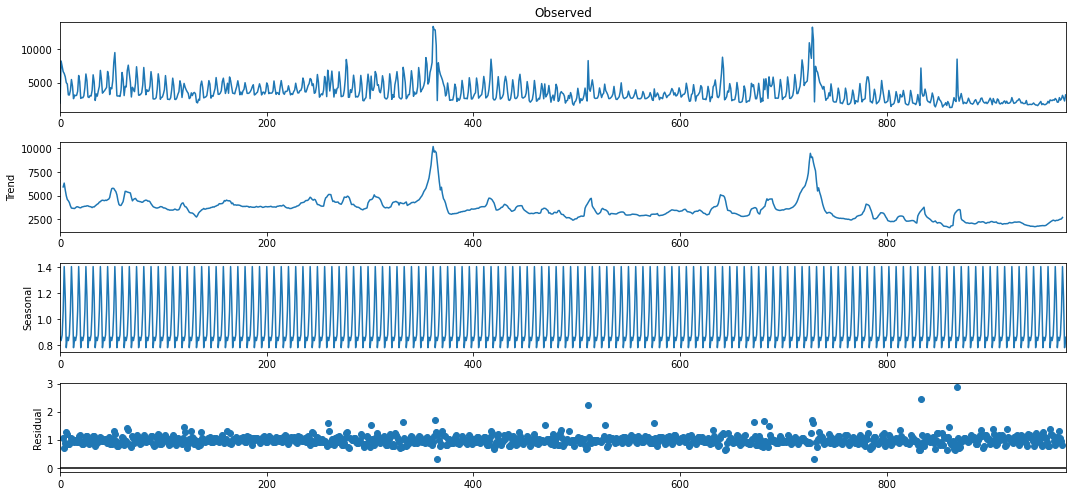

In [54]:

# multiplicative
resm = sm.tsa.seasonal_decompose(ts.values,period=7,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = resm.plot()
fig.show()

# salva resíduos
residuos = pd.DataFrame(resm.resid)
residuos = residuos.dropna()[0].to_numpy()

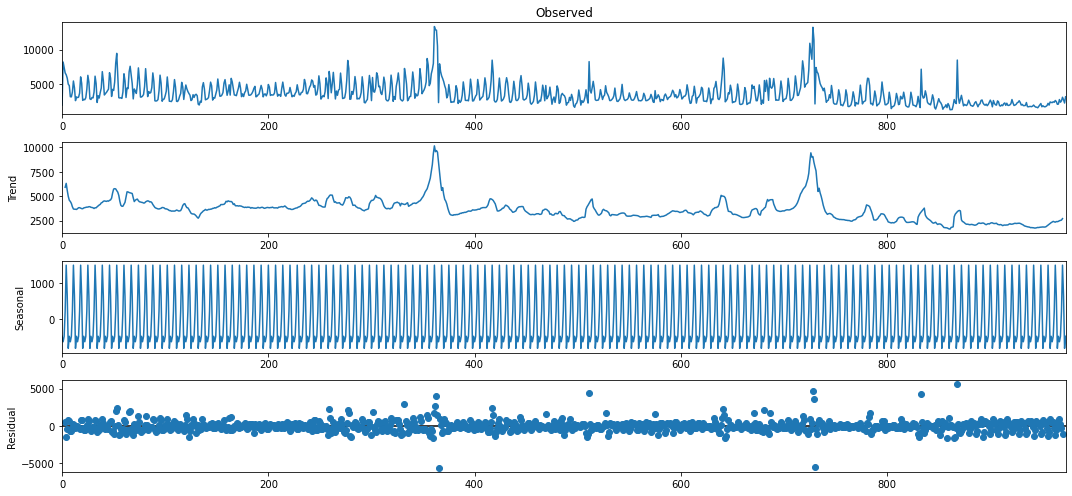

In [55]:
# multiplicative
resm = sm.tsa.seasonal_decompose(ts.values,period=7,model="additive")
#plt.figure(figsize=(16,12))
fig = resm.plot()
fig.show()

# salva resíduos
residuos = pd.DataFrame(resm.resid)
residuos = residuos.dropna()[0].to_numpy()

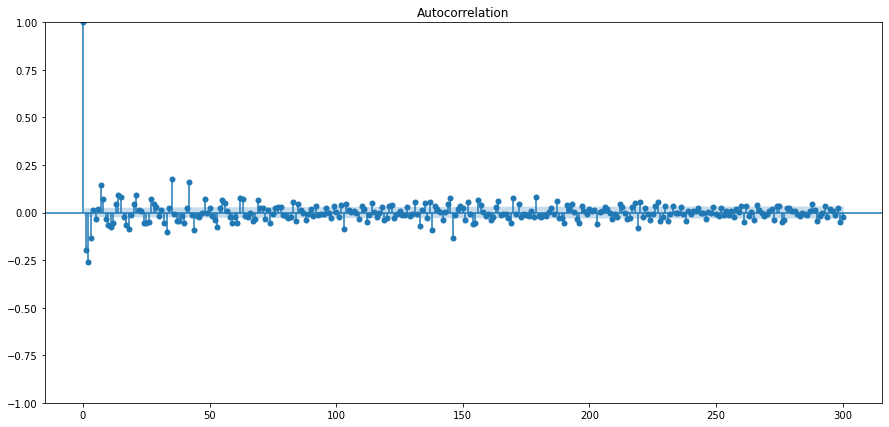

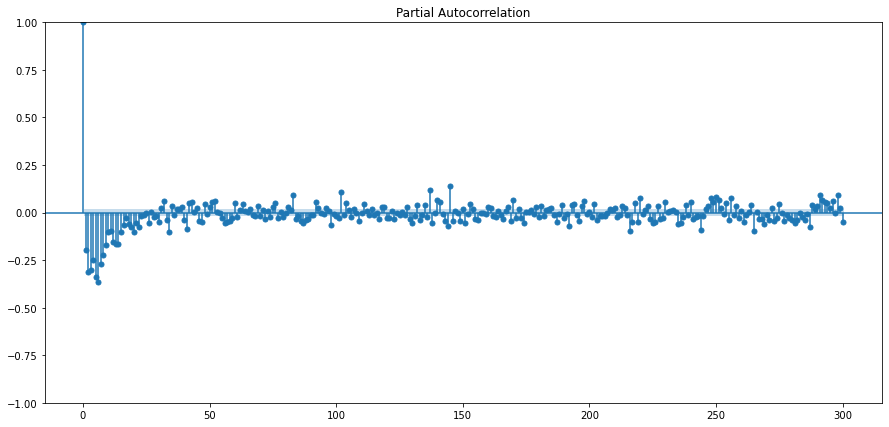

In [56]:
# k_diff = 1 gerou o melhor modelo até o momento
diff_ts = diff(residuos, seasonal_periods = 7,  k_diff = 1)
acf =smt.graphics.plot_acf(diff_ts, lags=300, alpha=0.5)
pacf = smt.graphics.plot_pacf(diff_ts, lags=300,  alpha=0.53)

In [57]:
test_stationarity(diff_ts)

Results of Dickey-Fuller Test:
Test Statistic                -1.466621e+01
p-value                        3.321337e-27
#Lags Used                     2.200000e+01
Number of Observations Used    9.440000e+02
Critical Value (1%)           -3.437296e+00
Critical Value (5%)           -2.864607e+00
Critical Value (10%)          -2.568403e+00
dtype: float64


In [58]:
arma_tune(diff_ts)

0 0 15992.321025816933
0 1 15526.89444333224
0 2 15464.807282278613
0 3 15179.082170284857
1 0 15955.151322583832
1 1 15495.831530986445
1 2 15458.58141513331
1 3 15467.818418671353
2 0 15857.235008003065
2 1 15369.284598215054
2 2 15115.251690813768
2 3 15058.38524368914
3 0 15765.330423845655
3 1 15296.83543748723
3 2 15090.286911330064
3 3 15019.40231793694
aic: 15019.40232 | order: (3, 3)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  968
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7489.650
Date:                Mon, 05 Dec 2022   AIC                          14995.301
Time:                        22:30:36   BIC                          15034.303
Sample:                             0   HQIC                         15010.147
                                - 968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0246      0.088     -0.279      0.780      -0.197       0.148
ar.L1          0.0190      0.296      0.064      0.949      -0.562       0.600
ar.L2          0.4032      0.292      1.379      0.1

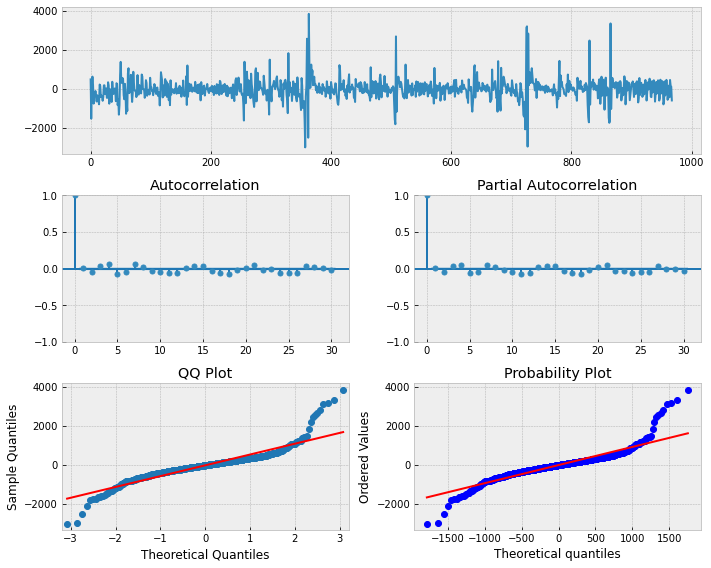

In [59]:
## antigo
model = ARIMA(residuos, order=(3, 0, 3)).fit()
resid_arma33 = model.resid
print(model.summary())
tsplot(resid_arma33)

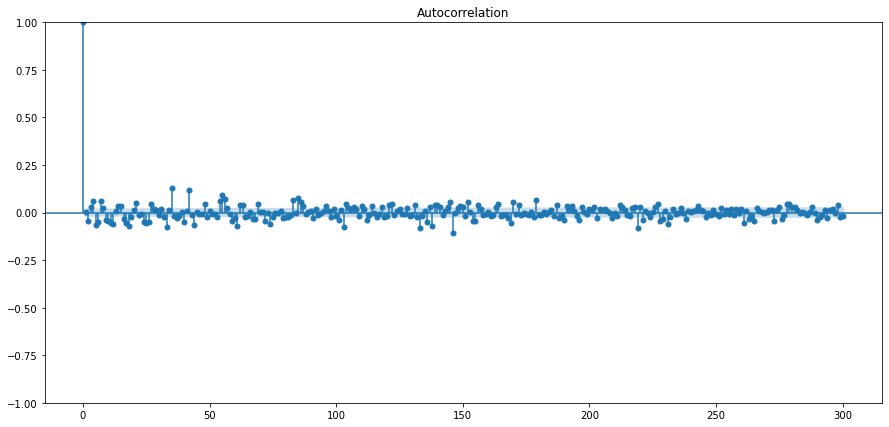

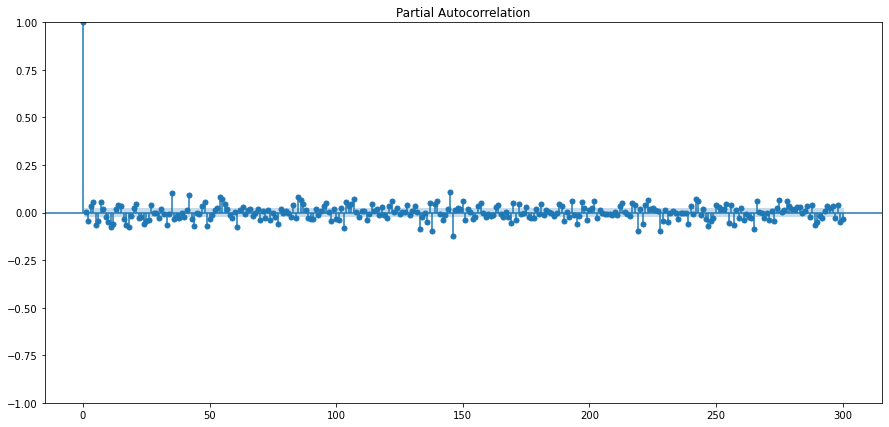

In [60]:
acf =smt.graphics.plot_acf(resid_arma33, lags=300, alpha=0.5)
pacf = smt.graphics.plot_pacf(resid_arma33, lags=300,  alpha=0.5)

In [61]:
sarima_tune(diff_ts)

0 0 0 15422.702418003872
0 1 0 15951.99919327315
0 2 0 16809.184567761993
0 3 0 17839.532335329688
0 0 1 15396.729202315037
0 1 1 15412.416029294214
0 2 1 15940.568285243822
0 3 1 16795.607094890584
0 0 2 15102.614349958323
0 1 2 15386.35458822582
0 2 2 15593.079537781497
0 3 2 7057.893948537023
0 0 3 15024.89904498584
0 1 3 15103.489438973258
0 2 3 15387.357092106417
0 3 3 15911.514413809115
1 0 0 15412.001210243558
1 1 0 15892.266640676073
1 2 0 16544.228067291777
1 3 0 17333.683594313632
1 0 1 15385.768632193649
1 1 1 15401.62524590065
1 2 1 15881.510723387712
1 3 1 16531.99100516439
1 0 2 15054.995846284943
1 1 2 15375.48318952954
1 2 2 15547.6881575839
1 3 2 16148.94136336393
1 0 3 15026.083947981839
1 1 3 15389.622655707906
1 2 3 15414.258103007036
1 3 3 15990.111686299924
2 0 0 15298.485051667514
2 1 0 15774.958493453356
2 2 0 16369.563042415555
2 3 0 17066.500061509687
2 0 1 14981.1743581056
2 1 1 15289.08523097858
2 2 1 15765.20051012755
2 3 1 16357.61883217214
2 0 2 14978.562

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  968
Model:             ARIMA(2, 2, 3)x(1, 0, [1], 7)   Log Likelihood                   0.000
Date:                           Mon, 05 Dec 2022   AIC                             16.000
Time:                                   22:32:47   BIC                             54.985
Sample:                                        0   HQIC                            30.842
                                           - 968                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -4.896e-07         -0        inf      0.000    -4.9e-07    -4.9e-07
ar.L2          1.0000         -0       -inf

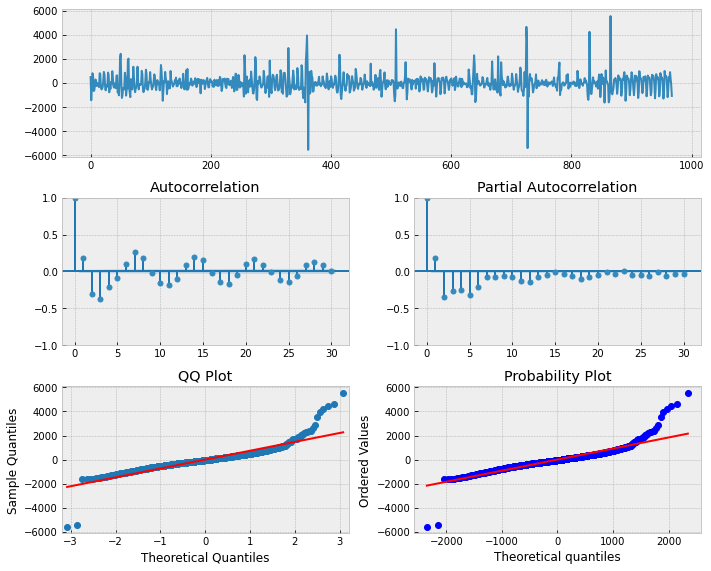

In [62]:
model = ARIMA(residuos, order=(2, 2, 3),seasonal_order=(1, 0, 1, 7) ).fit()
resid_arma33 = model.resid
print(model.summary())
tsplot(resid_arma33)

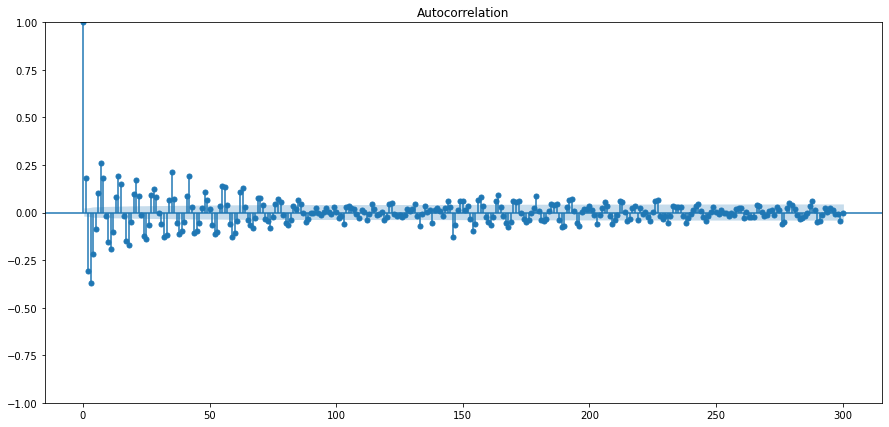

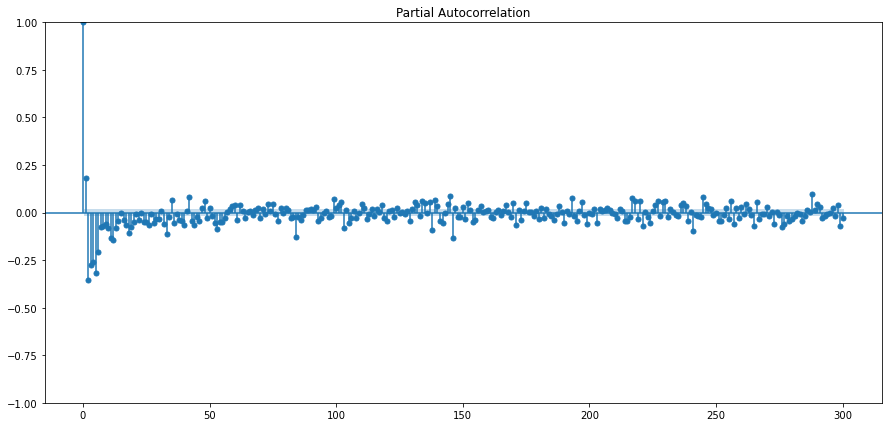

In [63]:
acf =smt.graphics.plot_acf(resid_arma33, lags=300, alpha=0.5)
pacf = smt.graphics.plot_pacf(resid_arma33, lags=300,  alpha=0.53)

In [64]:
arima_tune(diff_ts)

0 0 0 15533.066998951035
0 1 0 15990.323899230925
0 2 0 16817.43270449659
0 3 0 17841.670153658346
0 0 1 15471.44552642
0 1 1 15524.497333083555
0 2 1 15980.489508602026
0 3 1 16804.637147493624
0 0 2 15175.990272501153
0 1 2 15462.550008125178
0 2 2 15522.858702495998
0 3 2 15976.97104432024
0 0 3 15082.765570423593
0 1 3 15177.017282266428
0 2 3 15463.723369558174
0 3 3 15649.744794456885
1 0 0 15502.370299754912
1 1 0 15953.016182001558
1 2 0 16572.934129668985
1 3 0 17347.755319438424
1 0 1 15465.081482822708
1 1 1 15493.501868693927
1 2 1 15943.581004118121
1 3 1 16562.179075531814
1 0 2 15123.988033361606
1 1 2 15456.31448729936
1 2 2 15984.082191711277
1 3 2 15943.913699728433
1 0 3 15084.228065537274
1 1 3 15465.563647297085
1 2 3 15526.611190846877
1 3 3 15984.405051627302
2 0 0 15375.091669803736
2 1 0 15855.10109842792
2 2 0 16412.923152241136
2 3 0 17085.42662620997
2 0 1 15001.862910810974
2 1 1 15367.179779445583
2 2 1 15846.54107678376
2 3 1 16403.01142637072
2 0 2 14991

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  968
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7488.437
Date:                Mon, 05 Dec 2022   AIC                          14990.873
Time:                        22:33:54   BIC                          15025.000
Sample:                             0   HQIC                         15003.864
                                - 968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0260      0.088     -0.296      0.767      -0.198       0.146
ar.L1          1.0410      0.030     34.528      0.000       0.982       1.100
ar.L2         -0.5920      0.025    -23.556      0.0

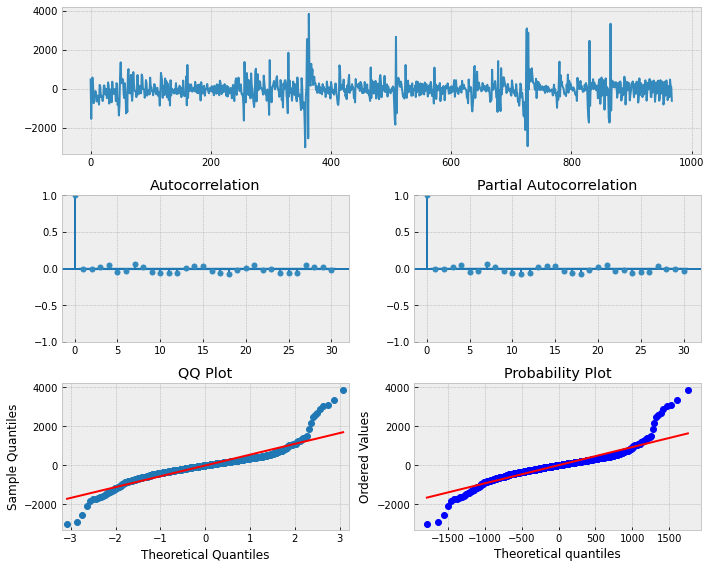

In [65]:
model = ARIMA(residuos, order=(2, 0, 3)).fit()
resid_arma33 = model.resid
print(model.summary())
tsplot(resid_arma33)

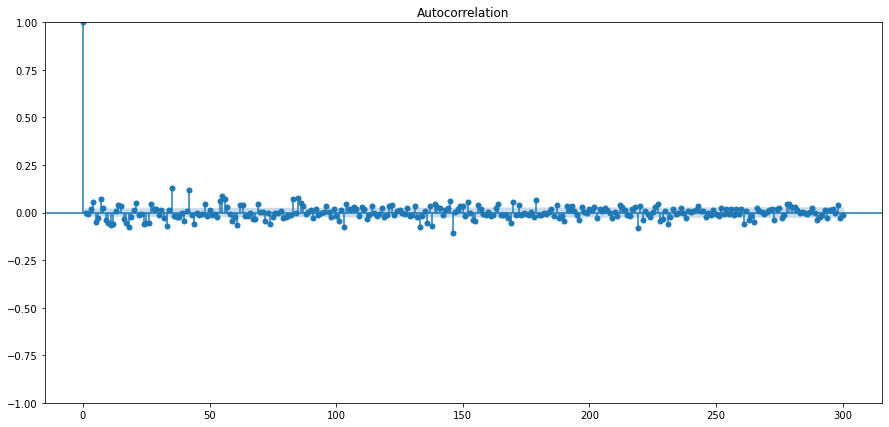

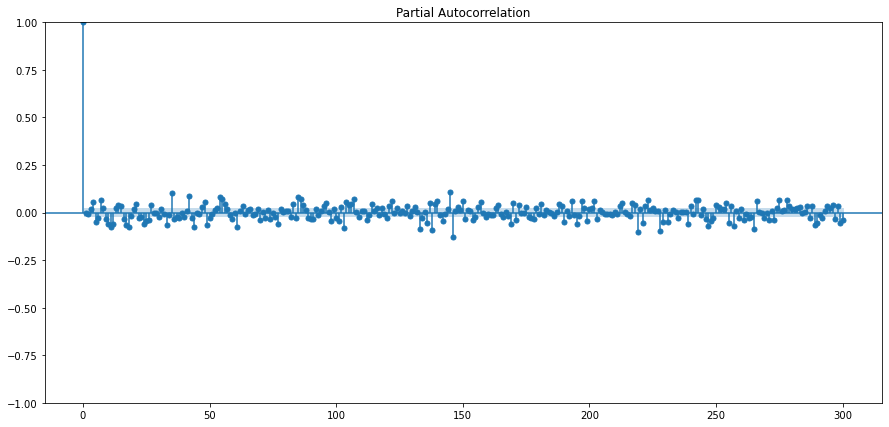

In [66]:
acf =smt.graphics.plot_acf(resid_arma33, lags=300, alpha=0.5)
pacf = smt.graphics.plot_pacf(resid_arma33, lags=300,  alpha=0.5)